<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DeepLearning/3_Redes_Multicapa/1_perceptron_multicapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Perceptron Multicapa

Hasta aquí hemos trabajado con modelos lineales o modelos de una sola capa. Es fácil entender porque estos modelos simples pueden fallar. Por ejemplo, hay fenómenos que pueden tener ciclos o frecuencias asociadas. O pueden existir situaciones donde una de nuestras categorías caiga en un rango acotado de valores (por ejemplo cantidad saludable de azucar en sangre)

Esto nos da a entender que debemos considerar más que solo modelos lineales

### Agregando capas ocultas

![](http://d2l.ai/_images/mlp.svg)

Sin embargo este modelo sigue siendo lineal:

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}. \\
    \mathbf{O} & = [\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}]\mathbf{W}^{(2)} + \mathbf{b}^{(2)} \\
    \mathbf{O} & = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(2)} \\
    \mathbf{O} & = \mathbf{X} \mathbf{W'} + \mathbf{b'} + \mathbf{b}^{(2)}\\
    \mathbf{O} & = \mathbf{X} \mathbf{W'} + \mathbf{b''}
\end{aligned}
$$

Si queremos un modelo más general, debemos usar algo más que solo capas lineales.

Para esto introducimos **funciones de activación**

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$


## Funciones de activacion


In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import numpy as np

A continuación graficaremos algunas funciones de activación y sus respectivas derivadas

### ReLU

$$\operatorname{ReLU}(x) = \max(0, x)$$


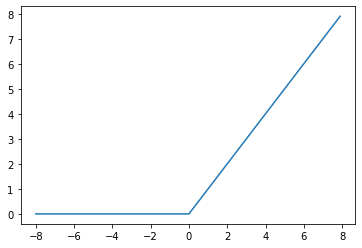

In [2]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
plt.plot(x.detach(), y.detach())

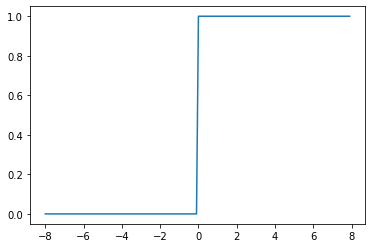

In [3]:
y.backward(torch.ones_like(x), retain_graph=True) # gradiente de y con respecto a x le calcula la derivada 
plt.plot(x.detach(), x.grad)

Existen varias alternativas similares a ReLU, sin embargo, queremos destactar a pReLU. A diferencia de ReLU, pReLU no descarta el gradiente a la izquierda. Además, el peso que se le otorgoa al gradiente a la izquierda es parte de los parámetros del modelo.

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

### Sigmoidea

$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

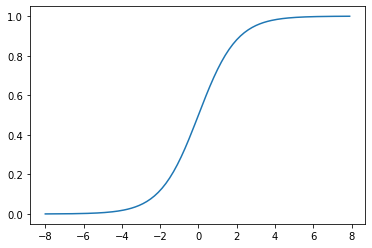

In [ ]:
y = torch.sigmoid(x)
plt.plot(x.detach(), y.detach())

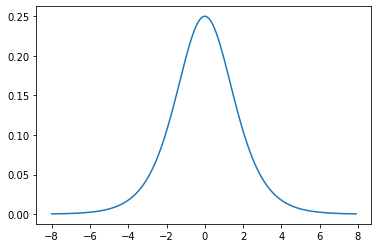

In [ ]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plt.plot(x.detach(), x.grad)

### Tangente hiperbólica

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

$$\operatorname{tanh}(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}.$$

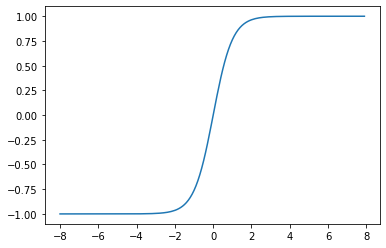

In [ ]:
y = torch.tanh(x)
plt.plot(x.detach(), y.detach())

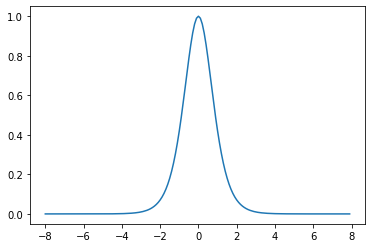

In [ ]:
# Clear out previous gradients.
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plt.plot(x.detach(), x.grad)

# Implementación de un perceptrón multicapa desde 0



In [ ]:
import torch
from torch import nn
import torchvision
from IPython import display
from torchvision import transforms
from torch.utils import data

In [ ]:
#Ejemplo de dataloader para FAshin MNIST

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))


In [ ]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

Como ven, vamos a volver a usar Fashion MNIST

## Inicialización de parametros.


In [ ]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

## Función de activación


In [ ]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## Modelo


In [ ]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # '@' multiplicacion de matrices
    return (H@W2 + b2)

## Función de pérdida


In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')

Recordemos que vamos a usar de nuevo la exactitud

In [ ]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

## Entrenamiento


In [ ]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

In [ ]:
num_epochs = 10
lr = 0.1
#features, labels = test_iter
for epoch in range(num_epochs):
    L = 0.0
    N = 0
    Acc = 0.0
    TestAcc = 0.0
    TestN = 0
    for X, y in train_iter:
        l = loss(net(X) ,y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()
        L += l.sum()
        # Aca el número de ejemplos
        N += l.numel()
        # Aca calcuamos exatitud
        Acc += accuracy(net(X), y)
    for X, y in test_iter:
        TestN += y.numel()
        TestAcc += accuracy(net(X), y)
    print(f'epoch {epoch + 1}, loss {(L/N):f}\
          , train accuracy  {(Acc/N):f}, test accuracy {(TestAcc/TestN):f}')

epoch 1, loss 1.039288          , train accuracy  0.656717, test accuracy 0.734400
epoch 2, loss 0.600367          , train accuracy  0.802367, test accuracy 0.777400
epoch 3, loss 0.518991          , train accuracy  0.831417, test accuracy 0.800200
epoch 4, loss 0.479947          , train accuracy  0.842800, test accuracy 0.823500
epoch 5, loss 0.455249          , train accuracy  0.850733, test accuracy 0.836200
epoch 6, loss 0.434863          , train accuracy  0.859933, test accuracy 0.811700
epoch 7, loss 0.419172          , train accuracy  0.863450, test accuracy 0.835300
epoch 8, loss 0.404052          , train accuracy  0.868300, test accuracy 0.832400
epoch 9, loss 0.393968          , train accuracy  0.873833, test accuracy 0.844500
epoch 10, loss 0.381902          , train accuracy  0.876950, test accuracy 0.829900


# Implementacion concisa


In [ ]:
import torch
from torch import nn
import torchvision
from IPython import display
from torchvision import transforms
from torch.utils import data

## Modelo


In [ ]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [ ]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
#Ejemplo de dataloader para FAshin MNIST

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=1),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=1))


In [ ]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [ ]:
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [ ]:
for epoch in range(num_epochs):
    L = 0.0
    N = 0
    Acc = 0.0
    TestAcc = 0.0
    TestN = 0
    for X, y in train_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.mean().backward()
        trainer.step()
        L += l.sum()
        N += l.numel()
        Acc += accuracy(net(X), y)
    for X, y in test_iter:
        TestN += y.numel()
        TestAcc += accuracy(net(X), y)
    print(f'epoch {epoch + 1}, loss {(L/N):f}\
          , train accuracy  {(Acc/N):f}, test accuracy {(TestAcc/TestN):f}')

epoch 1, loss 1.053460          , train accuracy  0.655217, test accuracy 0.760500
epoch 2, loss 0.597861          , train accuracy  0.801000, test accuracy 0.812400
epoch 3, loss 0.520889          , train accuracy  0.828950, test accuracy 0.819833
epoch 4, loss 0.478859          , train accuracy  0.842350, test accuracy 0.825400
epoch 5, loss 0.452455          , train accuracy  0.851650, test accuracy 0.848150
epoch 6, loss 0.432241          , train accuracy  0.858517, test accuracy 0.843850
epoch 7, loss 0.418598          , train accuracy  0.863700, test accuracy 0.847217
epoch 8, loss 0.406195          , train accuracy  0.868267, test accuracy 0.844933
epoch 9, loss 0.392574          , train accuracy  0.874050, test accuracy 0.857417
epoch 10, loss 0.382872          , train accuracy  0.876167, test accuracy 0.864250
